In [1]:
import os
import wget

# dataset 폴더 생성
os.makedirs("dataset", exist_ok=True)

# 다운로드할 파일들의 URL
file_urls = [
    "https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_x_train.csv",
    "https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_y_train.csv",
    "https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_x_test.csv",
    "https://raw.githubusercontent.com/aifactory-team/AFClass/master/1977/1977_y_test.csv"
]

# 파일 다운로드
for url in file_urls:
    filename = os.path.basename(url)
    file_path = os.path.join("dataset", filename)
    
    # 파일이 이미 존재하는지 확인 후 다운로드
    if not os.path.exists(file_path):
        wget.download(url, file_path)
    else:
        print(f"{filename} already exists, skipping download.")

1977_x_train.csv already exists, skipping download.
1977_y_train.csv already exists, skipping download.
1977_x_test.csv already exists, skipping download.
1977_y_test.csv already exists, skipping download.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

## 1. 데이터 불러오기 & 전처리


In [8]:
df_x = pd.read_csv("./dataset/1977_x_train.csv")
df_y = pd.read_csv("./dataset/1977_y_train.csv")
df = pd.concat([df_x, df_y], axis=1)

(1) integer index로 user와 movie를 encoding 수행

In [12]:
user_ids = df["userid"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
task_ids = df["taskid"].unique().tolist()
task2task_encoded = {x: i for i, x in enumerate(task_ids)}
task_encoded2task = {i: x for i, x in enumerate(task_ids)}
df["user"] = df["userid"].map(user2user_encoded)
df["task"] = df["taskid"].map(task2task_encoded)

num_users = len(user2user_encoded)
num_task = len(task_encoded2task)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
MIN_RATING = 0.5
MAX_RATING = 5.0

print(
    "Number of users: {}, Number of task: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_task, MIN_RATING, MAX_RATING
    )
)

Number of users: 13, Number of task: 102, Min rating: 0.5, Max rating: 5.0


## Prepare training and validation data


In [13]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "task"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - MIN_RATING) / (MAX_RATING - MIN_RATING)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).


In [14]:
EMBEDDING_SIZE = 128

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_task, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_task = num_task
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.task_embedding = layers.Embedding(
            num_task,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.task_bias = layers.Embedding(num_task, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        task_vector = self.task_embedding(inputs[:, 1])
        task_bias = self.task_bias(inputs[:, 1])
        dot_user_task = tf.tensordot(user_vector, task_vector, 2)
        # Add all the components (including bias)
        x = dot_user_task + user_bias + task_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_task, EMBEDDING_SIZE)
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.MeanSquaredError()])


## Train the model based on the data split


In [15]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=300,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/300
132/132 [==============================] - 1s 2ms/step - loss: 0.3485 - mean_squared_error: 0.3480 - val_loss: 0.3089 - val_mean_squared_error: 0.3084
Epoch 2/300
132/132 [==============================] - 0s 862us/step - loss: 0.3139 - mean_squared_error: 0.3134 - val_loss: 0.3052 - val_mean_squared_error: 0.3047
Epoch 3/300
132/132 [==============================] - 0s 830us/step - loss: 0.2811 - mean_squared_error: 0.2806 - val_loss: 0.3016 - val_mean_squared_error: 0.3011
Epoch 4/300
132/132 [==============================] - 0s 844us/step - loss: 0.2731 - mean_squared_error: 0.2726 - val_loss: 0.2996 - val_mean_squared_error: 0.2991
Epoch 5/300
132/132 [==============================] - 0s 838us/step - loss: 0.2657 - mean_squared_error: 0.2652 - val_loss: 0.2921 - val_mean_squared_error: 0.2916
Epoch 6/300
132/132 [==============================] - 0s 843us/step - loss: 0.2580 - mean_squared_error: 0.2575 - val_loss: 0.2913 - val_mean_squared_error: 0.2908
Epoch 7/300


## Plot training and validation loss


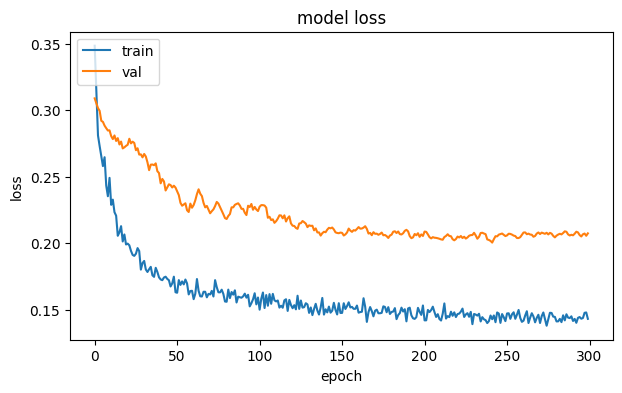

In [19]:
plt.figure(figsize=(7,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [20]:
df_x_test = pd.read_csv('./dataset/1977_x_test.csv')

In [21]:
df_x_test["user"] = df_x_test["userid"].map(user2user_encoded)
df_x_test["task"] = df_x_test["taskid"].map(task2task_encoded)

x_test = df_x_test[["user", "task"]].values

y_pred = model.predict(x_test)

5/5 [==============================] - 0s 771us/step


In [22]:
df_y_pred = pd.DataFrame(y_pred, columns=['rating'])
df_y_pred = df_y_pred["rating"].apply(lambda x: (x * (MAX_RATING - MIN_RATING) + MIN_RATING ))
df_y_pred.to_csv('./dataset/y_pred.csv', sep=',', columns = ['rating'], index = False)

### 평가하기

In [25]:
import os
import sys
import pandas as pd

from sklearn.metrics import mean_squared_error

gt = pd.read_csv('./dataset/1977_y_test.csv', header=0)
pr = pd.read_csv('./dataset/y_pred.csv', header=0)

gt = gt.to_numpy().astype(float).reshape(-1)
pr = pr.to_numpy().astype(float).reshape(-1)

score = mean_squared_error(gt, pr, squared=False)
print("score:", score)

score: 2.491325988455197
